STAT 453: Deep Learning (Spring 2021)  

Instructor: Sebastian Raschka (sraschka@wisc.edu)  
Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

In [1]:
#%load_ext watermark
#%watermark -a 'Sebastian Raschka' -v -p torch

- Runs on CPU or GPU (if available)

# L03: Perceptrons

Implementation of the classic Perceptron by Frank Rosenblatt for binary classification (here: 0/1 class labels) in PyTorch

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

## Preparing a toy dataset

In [3]:
##########################
### DATASET
##########################

data = np.genfromtxt('ALE_SensorNodeLocalization.txt', delimiter='\t')

X, y = data[:, :4], data[:, 4]
y = np.where(y>0.9, 0, 1)
y = y.astype(np.int)


print('Class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

# Shuffling & train/test split
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

X_train, X_test = X[shuffle_idx[:80]], X[shuffle_idx[80:]]
y_train, y_test = y[shuffle_idx[:80]], y[shuffle_idx[80:]]

# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

Class label counts: [53 54]
X.shape: (107, 4)
y.shape: (107,)


C:\Users\siu851463587\AppData\Local\Temp\ipykernel_8968\394963465.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = y.astype(np.int)


In [4]:
X_test

array([[ 1.45100379,  0.66138428, -0.98019606,  0.87475243],
       [ 1.45100379, -0.97166332, -0.98019606,  0.47302915],
       [-0.78992871, -0.6450538 , -0.98019606, -1.13386394],
       [-0.04295121,  0.66138428, -0.98019606,  0.07130588],
       [-0.78992871,  0.66138428,  0.42008403, -1.13386394],
       [ 0.25583979,  0.00816524, -0.98019606, -0.4911067 ],
       [-0.34174221,  1.64121284, -0.98019606, -1.29455325],
       [-0.78992871, -0.97166332, -0.98019606,  1.2764757 ],
       [-0.78992871,  0.66138428, -0.98019606,  0.07130588],
       [-0.78992871, -0.97166332, -0.98019606, -0.73214066],
       [-0.78992871, -0.97166332,  0.42008403,  0.87475243],
       [ 1.45100379, -0.97166332, -0.98019606,  1.2764757 ],
       [-0.78992871,  0.66138428, -0.98019606, -0.33041739],
       [-0.93932421, -0.31844428,  0.42008403, -1.13386394],
       [ 1.30160829,  2.29443187, -0.98019606,  0.87475243],
       [-0.78992871, -0.6450538 , -0.98019606, -1.29455325],
       [-0.78992871, -0.

In [5]:
y_train

array([1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0])

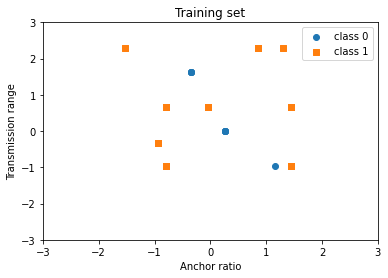

In [6]:
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.title('Training set')
plt.xlabel('Anchor ratio')
plt.ylabel('Transmission range')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend()
plt.show()

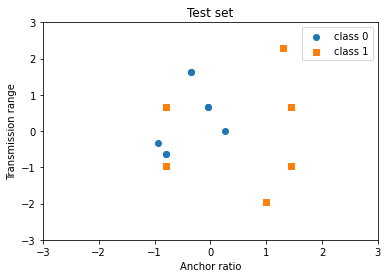

In [7]:
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')
plt.title('Test set')
plt.xlabel('Anchor ratio')
plt.ylabel('Transmission range')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend()
plt.show()

## Defining the Perceptron model

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Perceptron():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)
        
        # placeholder vectors so they don't
        # need to be recreated each time
        self.ones = torch.ones(1).to('cpu')  #Ahmed: added to.('cuda') to send tensors used in prediction to GPU device
        self.zeros = torch.zeros(1).to('cpu')

    def forward(self, x):
        linear = torch.mm(x, self.weights) + self.bias      # compute the net input
        print(linear)
        predictions = torch.where(linear > 0., self.ones, self.zeros)       # set threshold
        return predictions
        
    def backward(self, x, y):  
        predictions = self.forward(x)
        errors = y - predictions
        return errors
        
    def train(self, x, y, epochs):
        for e in range(epochs):
            
            for i in range(y.shape[0]):
                # use view because backward expects a matrix (i.e., 2D tensor)
                errors = self.backward(x[i].reshape(1, self.num_features), y[i]).reshape(-1)
                self.weights += (errors * x[i]).reshape(self.num_features, 1)
                self.bias += errors
                
    def evaluate(self, x, y):
        predictions = self.forward(x).reshape(-1)
        accuracy = torch.sum(predictions == y).float() / y.shape[0]
        return accuracy

## Training the Perceptron

In [9]:
ppn = Perceptron(num_features=4)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

ppn.train(X_train_tensor, y_train_tensor, epochs=100)

print('Model parameters:')
print('  Weights: %s' % ppn.weights)
print('  Bias: %s' % ppn.bias)

tensor([[0.]])
tensor([[3.1759]])
tensor([[-1.6042]])
tensor([[1.4188]])
tensor([[2.4148]])
tensor([[-1.3725]])
tensor([[0.5882]])
tensor([[-1.3725]])
tensor([[1.4544]])
tensor([[-2.8745]])
tensor([[-0.5308]])
tensor([[7.0147]])
tensor([[0.7386]])
tensor([[1.8289]])
tensor([[1.3864]])
tensor([[7.4553]])
tensor([[0.7705]])
tensor([[-7.6353]])
tensor([[-1.5450]])
tensor([[4.7371]])
tensor([[-4.0379]])
tensor([[-2.8979]])
tensor([[4.7972]])
tensor([[7.0449]])
tensor([[-1.4063]])
tensor([[4.5560]])
tensor([[8.8801]])
tensor([[5.8034]])
tensor([[-2.3039]])
tensor([[1.0665]])
tensor([[-2.0034]])
tensor([[-1.7644]])
tensor([[6.1917]])
tensor([[3.6450]])
tensor([[-3.9600]])
tensor([[-5.5419]])
tensor([[-5.0219]])
tensor([[0.0177]])
tensor([[-4.8891]])
tensor([[0.1504]])
tensor([[-4.6236]])
tensor([[0.5952]])
tensor([[5.7429]])
tensor([[0.5815]])
tensor([[0.4050]])
tensor([[-3.7944]])
tensor([[-0.0046]])
tensor([[2.6581]])
tensor([[3.1032]])
tensor([[0.4952]])
tensor([[-2.5769]])
tensor([[3.694

In [10]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

test_acc = ppn.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

tensor([[  0.9108],
        [ -7.7031],
        [-23.2383],
        [ -8.4185],
        [  0.3002],
        [-13.8063],
        [-14.9084],
        [ -8.0965],
        [-10.3630],
        [-21.6970],
        [  8.0069],
        [ -2.2629],
        [-13.0831],
        [ -3.6249],
        [  6.4156],
        [-24.3264],
        [-10.8166],
        [  9.0711],
        [ 21.3903],
        [ -7.2495],
        [-15.4524],
        [-10.4231],
        [ -4.9830],
        [-13.5367],
        [  2.9602],
        [ 18.1688],
        [-16.5788]])
Test set accuracy: 96.30%


C:\Users\siu851463587\OneDrive - Southern Illinois University\Desktop\DeepLearning\venv\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
C:\Users\siu851463587\OneDrive - Southern Illinois University\Desktop\DeepLearning\venv\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating

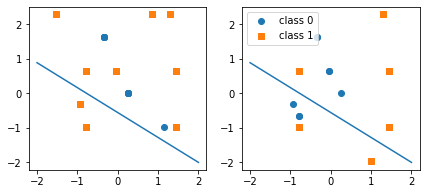

In [11]:
##########################
### 2D Decision Boundary
##########################

w, b = ppn.weights.cpu(), ppn.bias.cpu()  #Ahmed: used .cpu() to send tensors from device to CPU

x0_min = -2
x1_min = ( (-(w[0] * x0_min) - b[0]) 
          / w[1] )

x0_max = 2
x1_max = ( (-(w[0] * x0_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x0_min, x0_max], [x1_min, x1_max])
ax[1].plot([x0_min, x0_max], [x1_min, x1_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()